In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders


loc = "/content/drive/MyDrive/피부질환 classification/IMG_CLASSES"

splitfolders.ratio(loc,output = "/content/drive/MyDrive/피부질환 classification/피부질환 데이터셋 final",seed = 1337,ratio = (0.75,0.15,0.1))

Copying files: 26131 files [15:24, 28.26 files/s] 


In [3]:
from tensorflow.keras import regularizers

In [4]:
# dropout 층 추가 & l2 람다 줄임

from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Multiply
from keras.models import Model
from keras import backend as K
from keras.utils.layer_utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

!pip install keras_applications
!pip install keras_preprocessing
from keras_applications.imagenet_utils import _obtain_input_shape

def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[..., ::-1]
    
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68

    # Scale
    x *= 0.017
    return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
        
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)

    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])

    x = layers.add([x, input_tensor], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
    
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, strides=strides, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)
    
    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=False, name=conv_name_base + '_prj')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_prj_bn')(shortcut)

    x = layers.add([x, shortcut], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def SEResNet50(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=225,
                                      min_size=160,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(classes, kernel_regularizer=regularizers.l2(0.00001), activation='softmax', name='fc6')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='se-resnet50')
    return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
model = SEResNet50(weights='imagenet', input_shape=(225, 225, 3), classes=10)
model.summary()

Model: "se-resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 225, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 113, 113, 64  256         ['conv1[0][0]']                  
                                )                                                       

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/content/drive/MyDrive/피부질환 classification/피부질환 데이터셋 final/train"
test_dir =  "/content/drive/MyDrive/피부질환 classification/피부질환 데이터셋 final/test"
val_dir = "/content/drive/MyDrive/피부질환 classification/피부질환 데이터셋 final/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = False,seed = 42)

Found 19594 files belonging to 10 classes.
Found 2622 files belonging to 10 classes.
Found 3915 files belonging to 10 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import seaborn as sns
import os

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

# 체크포인트 폴더 생성 
base = '/content/drive/MyDrive/피부질환 classification/checkpoint'
checkpoint_dir = os.path.join(base,'checkpoint')
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

#성능이 개선될 때마다 모델 저장 
model_path = checkpoint_dir+  '/{epoch:02d}-{val_accuracy:.4f}.hdf5'

from keras.callbacks import ModelCheckpoint

#각 epoch마다 val_acc 값을 모니터링
#save_best_only=True : 이전보다 성능이 개선됐을때만 저장
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [early_stop, reduce_lr, checkpoint]

In [8]:
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
import torch 

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [10]:
!nvidia-smi

Wed Dec  7 14:31:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |    566MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import numpy as np

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = optimizer, metrics = ["accuracy"])

history_1 = model.fit(train_data, epochs = 50, validation_data=val_data, callbacks=callbacks_list)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 1.7410 - accuracy: 0.5327
Epoch 1: val_accuracy improved from -inf to 0.54278, saving model to /content/drive/MyDrive/피부질환 classification/checkpoint/checkpoint/01-0.5428.hdf5
613/613 [==============================] - 267s 406ms/step - loss: 1.7410 - accuracy: 0.5327 - val_loss: 1.8059 - val_accuracy: 0.5428 - lr: 1.0000e-04
Epoch 2/50
613/613 [==============================] - ETA: 0s - loss: 1.0077 - accuracy: 0.6521
Epoch 2: val_accuracy improved from 0.54278 to 0.63193, saving model to /content/drive/MyDrive/피부질환 classification/checkpoint/checkpoint/02-0.6319.hdf5
613/613 [==============================] - 251s 408ms/step - loss: 1.0077 - accuracy: 0.6521 - val_loss: 1.0522 - val_accuracy: 0.6319 - lr: 1.0000e-04
Epoch 3/50
613/613 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.7187
Epoch 3: val_accuracy improved from 0.63193 to 0.65236, saving model to /content/drive/MyDrive/피부질환 

In [12]:
history_2 = model.fit(train_data, epochs = 30, validation_data=val_data, callbacks=callbacks_list)

Epoch 1/30
613/613 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9853
Epoch 1: val_accuracy improved from 0.74713 to 0.74866, saving model to /content/drive/MyDrive/피부질환 classification/checkpoint/checkpoint/01-0.7487.hdf5
613/613 [==============================] - 250s 407ms/step - loss: 0.0608 - accuracy: 0.9853 - val_loss: 0.9843 - val_accuracy: 0.7487 - lr: 2.0000e-05
Epoch 2/30
613/613 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9878
Epoch 2: val_accuracy did not improve from 0.74866
613/613 [==============================] - 249s 405ms/step - loss: 0.0493 - accuracy: 0.9878 - val_loss: 1.0871 - val_accuracy: 0.7410 - lr: 2.0000e-05
Epoch 3/30
613/613 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9893
Epoch 3: val_accuracy did not improve from 0.74866
613/613 [==============================] - 249s 406ms/step - loss: 0.0531 - accuracy: 0.9893 - val_loss: 1.1240 - val_accuracy: 0.7344 - lr: 2.0000e

In [13]:
print("Validation Accuracy",model.evaluate(val_data))
print("Testing Accuracy",model.evaluate(test_data))

123/123 [==============================] - 14s 111ms/step - loss: 1.0630 - accuracy: 0.7499
Validation Accuracy [1.0629749298095703, 0.7499361634254456]
82/82 [==============================] - 10s 126ms/step - loss: 1.1166 - accuracy: 0.7525
Testing Accuracy [1.116645097732544, 0.7524790167808533]


In [14]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

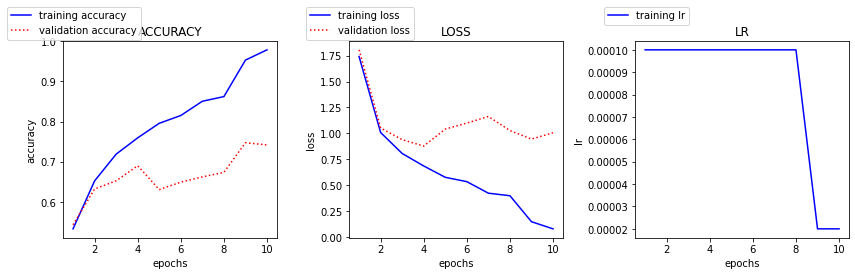

In [15]:
import matplotlib.pyplot as plt

plot_history(history_1)

# 모델 Evaluation

In [16]:
pred_probs = model.predict(test_data)
pred_probs[0]

82/82 [==============================] - 10s 111ms/step


array([2.12937994e-05, 8.37979615e-02, 2.60485631e-05, 6.94024503e-01,
       1.51515231e-01, 5.82556650e-02, 6.10917108e-04, 1.10322471e-08,
       1.15926005e-02, 1.55826870e-04], dtype=float32)

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
origin_train_data_dir = '/content/drive/MyDrive/피부질환 classification/피부질환 데이터셋 final/train'
origin_train_data = image_dataset_from_directory(origin_train_data_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = True,seed = 42)

class_names = origin_train_data.class_names
print(len(class_names))
print(class_names)

pred_classes = pred_probs.argmax(axis =1)
print(pred_classes[0])
print(class_names[pred_classes[0]])

Found 19594 files belonging to 10 classes.
10
['1. Eczema(습진)', '10. Warts Molluscum(사마귀 및 바이러스 감염)', '2. Melanoma(흑색종)', '3. Atopic Dermatitis(아토피 피부염)', '4. Basal Cell Carcinoma(기저 세포 암)', '5. Melanocytic Nevi (멜라닌 세포 모반)', '6. Benign Keratosis-like Lesions(양성 각화증 유사 병변)', '7. normal(정상)', '8. Seborrheic Keratoses and other Benign Tumors(지루성 각화증 및 기타 양성 종양)', '9. Tinea Ringworm Candidiasis(백선 칸디다증 및 기타 곰팡이 감염)']
3
3. Atopic Dermatitis(아토피 피부염)


In [18]:
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
y_labels[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
print(len(pred_classes))
print(len(y_labels))

2622
2622


In [20]:
from sklearn.metrics import classification_report
print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.46      0.57      0.51       169
           1       0.54      0.40      0.46       211
           2       0.95      0.93      0.94       314
           3       0.46      0.35      0.40       127
           4       0.77      0.88      0.82       335
           5       0.90      0.96      0.93       798
           6       0.75      0.44      0.55       209
           7       1.00      1.00      1.00       103
           8       0.57      0.56      0.56       185
           9       0.47      0.55      0.51       171

    accuracy                           0.75      2622
   macro avg       0.69      0.66      0.67      2622
weighted avg       0.75      0.75      0.74      2622



In [21]:
classification_dict = classification_report(y_labels,pred_classes,output_dict = True)
classification_dict

{'0': {'precision': 0.45539906103286387,
  'recall': 0.5739644970414202,
  'f1-score': 0.5078534031413612,
  'support': 169},
 '1': {'precision': 0.535031847133758,
  'recall': 0.3981042654028436,
  'f1-score': 0.4565217391304348,
  'support': 211},
 '2': {'precision': 0.9509803921568627,
  'recall': 0.9267515923566879,
  'f1-score': 0.9387096774193548,
  'support': 314},
 '3': {'precision': 0.45918367346938777,
  'recall': 0.3543307086614173,
  'f1-score': 0.4,
  'support': 127},
 '4': {'precision': 0.7668393782383419,
  'recall': 0.8835820895522388,
  'f1-score': 0.8210818307905687,
  'support': 335},
 '5': {'precision': 0.8962703962703963,
  'recall': 0.9636591478696742,
  'f1-score': 0.928743961352657,
  'support': 798},
 '6': {'precision': 0.7459016393442623,
  'recall': 0.4354066985645933,
  'f1-score': 0.5498489425981874,
  'support': 209},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 103},
 '8': {'precision': 0.569060773480663,
  'recall': 0.5567567567567

In [22]:
classification_f1_scores = {}
for k,v in classification_dict.items():
    if k == "accuracy":
        break
    else:
        classification_f1_scores[class_names[int(k)]] = v["f1-score"]
classification_f1_scores

{'1. Eczema(습진)': 0.5078534031413612,
 '10. Warts Molluscum(사마귀 및 바이러스 감염)': 0.4565217391304348,
 '2. Melanoma(흑색종)': 0.9387096774193548,
 '3. Atopic Dermatitis(아토피 피부염)': 0.4,
 '4. Basal Cell Carcinoma(기저 세포 암)': 0.8210818307905687,
 '5. Melanocytic Nevi (멜라닌 세포 모반)': 0.928743961352657,
 '6. Benign Keratosis-like Lesions(양성 각화증 유사 병변)': 0.5498489425981874,
 '7. normal(정상)': 1.0,
 '8. Seborrheic Keratoses and other Benign Tumors(지루성 각화증 및 기타 양성 종양)': 0.5628415300546447,
 '9. Tinea Ringworm Candidiasis(백선 칸디다증 및 기타 곰팡이 감염)': 0.5094850948509484}